In [ ]:
#!/usr/bin/env python3
"""
1D-CNN Autoencoder for STEAD Noise
Unsupervised time-series anomaly detection

"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, UpSampling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split


# ============================================================
# CONFIGURATION
# ============================================================
DATA_PATH = "/Users/selinbardakci/BitirmeProjesi/webapp/trainData/z_channel_train.pkl"

print("🔎 Checking path:", DATA_PATH)
print("Exists?", os.path.exists(DATA_PATH))

if not os.path.exists(DATA_PATH):
    print("\n📂 Listing anomaly_selin folder:")
    !ls /content/drive/MyDrive/anomaly_selin
    print("\n📂 Listing Data folder:")
    !ls /content/drive/MyDrive/anomaly_selin/Data
    raise FileNotFoundError("❌ Noise training file not found")

df = pd.read_pickle(DATA_PATH)

LOOKBACK = 128
STRIDE = 64
BATCH_SIZE = 256          # CNN loves big batches
EPOCHS = 50
MAX_TRACES = 4000
MAX_WINDOWS_PER_TRACE = 100
RANDOM_SEED = 42

MODEL_DIR = "/content/drive/MyDrive/anomaly_selin/models"
os.makedirs(MODEL_DIR, exist_ok=True)


# ============================================================
# LOAD DATA
# ============================================================
print("🔹 Loading STEAD noise data...")
df = pd.read_pickle(DATA_PATH)

df = df.sample(n=MAX_TRACES, random_state=RANDOM_SEED).reset_index(drop=True)
print(f"Loaded {len(df)} noise traces")


# ============================================================
# WINDOWING
# ============================================================
def make_windows(signal, win=128, stride=64):
    windows = []
    for i in range(0, len(signal) - win, stride):
        windows.append(signal[i:i + win])
    return np.array(windows, dtype=np.float32)


print("\n🔹 Building training windows...")
X_all = []

for z in df["Z_channel"]:
    z = np.asarray(z, dtype=np.float32)
    z = (z - z.mean()) / (z.std() + 1e-6)

    windows = make_windows(z, LOOKBACK, STRIDE)

    if len(windows) > MAX_WINDOWS_PER_TRACE:
        idx = np.random.choice(len(windows), MAX_WINDOWS_PER_TRACE, replace=False)
        windows = windows[idx]

    X_all.append(windows)

X = np.vstack(X_all)[..., np.newaxis]

print("Total windows:", X.shape)


# ============================================================
# TRAIN / VAL SPLIT
# ============================================================
X_train, X_val = train_test_split(
    X, test_size=0.2, random_state=RANDOM_SEED, shuffle=True
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)


# ============================================================
# 1D-CNN AUTOENCODER
# ============================================================
print("\n🔹 Building 1D-CNN Autoencoder...")

inp = Input(shape=(LOOKBACK, 1))

# -------- Encoder --------
x = Conv1D(32, 7, activation="relu", padding="same")(inp)
x = MaxPooling1D(2, padding="same")(x)

x = Conv1D(64, 5, activation="relu", padding="same")(x)
x = MaxPooling1D(2, padding="same")(x)

x = Conv1D(128, 3, activation="relu", padding="same")(x)

# -------- Decoder --------
x = UpSampling1D(2)(x)
x = Conv1D(64, 5, activation="relu", padding="same")(x)

x = UpSampling1D(2)(x)
x = Conv1D(32, 7, activation="relu", padding="same")(x)

out = Conv1D(1, 7, padding="same")(x)

model = Model(inp, out)
model.compile(optimizer="adam", loss="mse")

model.summary()


# ============================================================
# CALLBACKS
# ============================================================
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, "cnn_ae_best.keras"),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


# ============================================================
# TRAIN
# ============================================================
print("\n🚀 Training 1D-CNN Autoencoder...")

history = model.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[early_stop, checkpoint]
)


# ============================================================
# SAVE FINAL MODEL
# ============================================================
final_path = os.path.join(MODEL_DIR, "cnn_ae_final.keras")
model.save(final_path)

print("\n✅ Training complete")
print(f"Best model : {MODEL_DIR}/cnn_ae_best.keras")
print(f"Final model: {final_path}")


🔎 Checking path: /content/drive/MyDrive/anomaly_selin/Data/df_noise_train.pkl
Exists? True
🔹 Loading STEAD noise data...
Loaded 4000 noise traces

🔹 Building training windows...
Total windows: (368000, 128, 1)
Train: (294400, 128, 1)
Val  : (73600, 128, 1)

🔹 Building 1D-CNN Autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 128, 32)        │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 128, 1)         │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,881 (355.00 KB)

 Trainable params: 90,881 (355.00 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training 1D-CNN Autoencoder...
Epoch 1/50
1146/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1194
Epoch 1: val_loss improved from inf to 0.00606, saving model to /content/drive/MyDrive/anomaly_selin/models/cnn_ae_best.keras
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - loss: 0.1191 - val_loss: 0.0061
Epoch 2/50
1145/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055
Epoch 2: val_loss improved from 0.00606 to 0.00339, saving model to /content/drive/MyDrive/anomaly_selin/models/cnn_ae_best.keras
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0055 - val_loss: 0.0034
Epoch 3/50
1149/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034
Epoch 3: val_loss improved from 0.00339 to 0.00335, saving model to /content/drive/MyDrive/anomaly_selin/models/cnn_ae_best.keras
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 4/50
1145/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027
Epoch 4: val_loss improved from 0.00335 to 0.00204, saving model to

🔹 Loading trained 1D-CNN Autoencoder...
✅ Model loaded

🔹 Loading saved custom test dataset...
✅ Loaded
X shape: (54324, 128, 1)  y shape: (54324,)
Noise windows: 24681  EQ windows: 29643

🔹 Running reconstruction...
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step

📊 ERROR STATS
Mean  : 0.0004326400230638683
Median: 4.0801791328703985e-05
Std   : 0.0021237945184111595

📊 ROC AUC (CNN)
AUC: 0.94951488834112


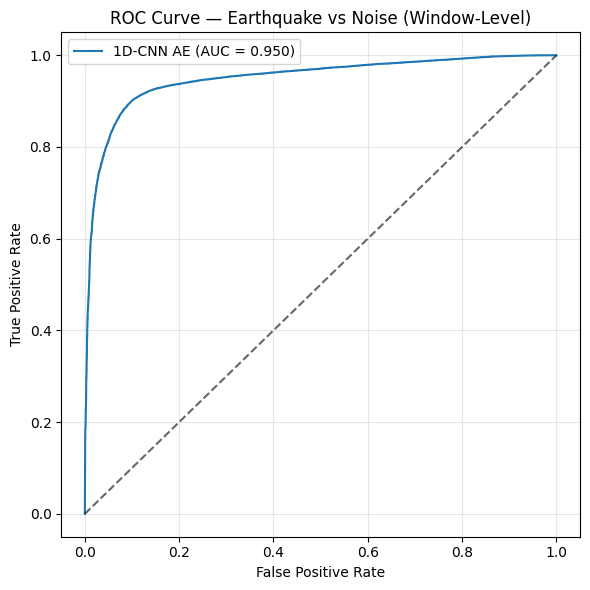

In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# =========================
# PATHS
# =========================
MODEL_PATH = "./cnn_ae_best.keras"
TEST_NPZ   = "/Users/selinbardakci/BitirmeProjesi/data/custom_window_test.npz"

# =========================
# LOAD MODEL
# =========================
print("🔹 Loading trained 1D-CNN Autoencoder...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded")

# =========================
# LOAD SAVED CUSTOM TEST SET
# =========================
print("\n🔹 Loading saved custom test dataset...")
data = np.load(TEST_NPZ)
X = data["X"]   # (N, 128, 1)
y = data["y"]   # (N,)
print("✅ Loaded")
print("X shape:", X.shape, " y shape:", y.shape)
print("Noise windows:", (y==0).sum(), " EQ windows:", (y==1).sum())

# =========================
# RECONSTRUCTION ERROR
# =========================
print("\n🔹 Running reconstruction...")
X_hat = model.predict(X, batch_size=256, verbose=1)

errors = np.mean((X - X_hat) ** 2, axis=(1, 2))

print("\n📊 ERROR STATS")
print("Mean  :", float(errors.mean()))
print("Median:", float(np.median(errors)))
print("Std   :", float(errors.std()))

# =========================
# ROC + AUC
# =========================
fpr, tpr, thr = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

print("\n📊 ROC AUC (CNN)")
print("AUC:", roc_auc)

# =========================
# PLOT
# =========================
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"1D-CNN AE (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Earthquake vs Noise (Window-Level)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



🔍 ANALYSIS FOR p97 THRESHOLD
Threshold (p97): 7.00958713e-05
Confusion matrix [[TN FP],[FN TP]]:
[[23940   741]
 [ 7587 22056]]
Precision: 0.967
Recall   : 0.744
Flag rate: 0.420


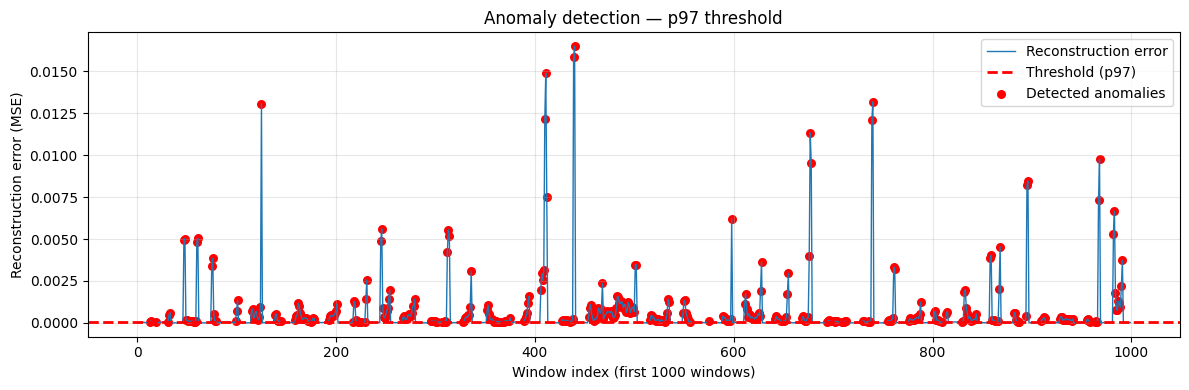

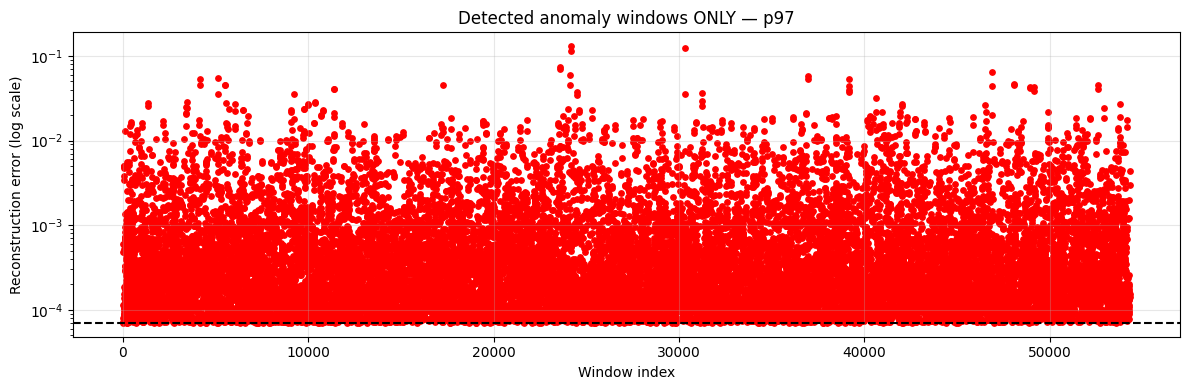


🔍 ANALYSIS FOR p99 THRESHOLD
Threshold (p99): 1.43319718e-04
Confusion matrix [[TN FP],[FN TP]]:
[[24434   247]
 [13662 15981]]
Precision: 0.985
Recall   : 0.539
Flag rate: 0.299


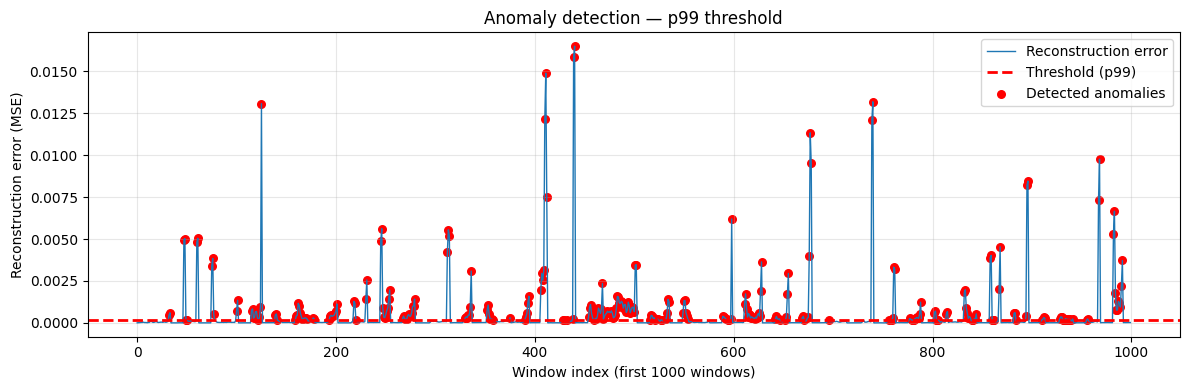

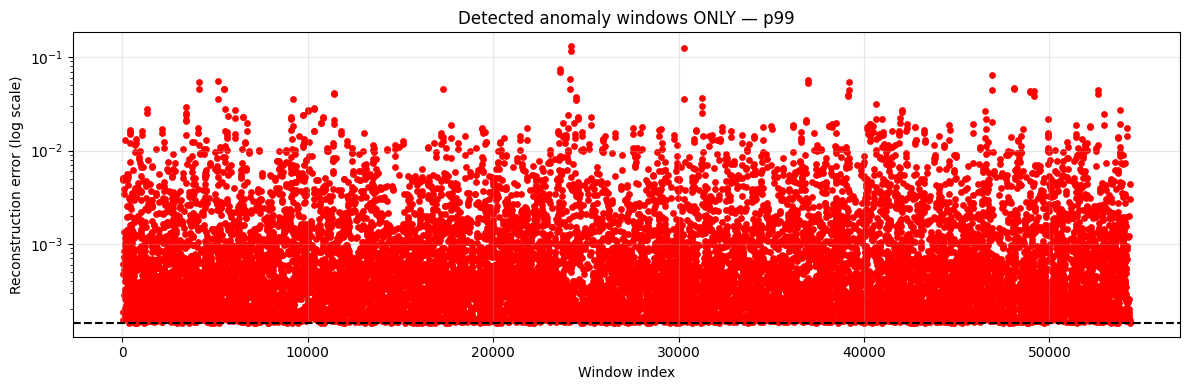

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---------------------------------
# ASSUMPTION:
# Bu cell çalışmadan önce şunlar TANIMLI:
# errors, y
# ---------------------------------

noise_errors = errors[y == 0]

PERCENTILES = [97, 99]
N_SHOW = 1000   # ilk kaç pencere gösterilecek

for P in PERCENTILES:
    print("\n" + "="*60)
    print(f"🔍 ANALYSIS FOR p{P} THRESHOLD")
    print("="*60)

    THRESHOLD = np.percentile(noise_errors, P)
    print(f"Threshold (p{P}): {THRESHOLD:.8e}")

    # -----------------------------
    # Predictions
    # -----------------------------
    y_pred = (errors > THRESHOLD).astype(int)

    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)

    print("Confusion matrix [[TN FP],[FN TP]]:")
    print(cm)
    print(f"Precision: {precision:.3f}")
    print(f"Recall   : {recall:.3f}")
    print(f"Flag rate: {y_pred.mean():.3f}")

    # =========================================================
    # GRAPHIC 1 — FIRST 1000 WINDOWS (same as before)
    # =========================================================
    errors_sub = errors[:N_SHOW]
    is_anomaly_sub = errors_sub > THRESHOLD

    plt.figure(figsize=(12,4))
    plt.plot(errors_sub, lw=1, label="Reconstruction error")
    plt.axhline(
        THRESHOLD,
        color="red",
        linestyle="--",
        lw=2,
        label=f"Threshold (p{P})"
    )
    plt.scatter(
        np.where(is_anomaly_sub)[0],
        errors_sub[is_anomaly_sub],
        color="red",
        s=30,
        label="Detected anomalies"
    )

    plt.xlabel(f"Window index (first {N_SHOW} windows)")
    plt.ylabel("Reconstruction error (MSE)")
    plt.title(f"Anomaly detection — p{P} threshold")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # =========================================================
    # GRAPHIC 2 — ONLY ANOMALIES (log scale)
    # =========================================================
    anomaly_idx = np.where(errors > THRESHOLD)[0]

    plt.figure(figsize=(12,4))
    plt.scatter(anomaly_idx, errors[anomaly_idx], s=15, color="red")
    plt.axhline(THRESHOLD, linestyle="--", color="black")

    plt.yscale("log")
    plt.xlabel("Window index")
    plt.ylabel("Reconstruction error (log scale)")
    plt.title(f"Detected anomaly windows ONLY — p{P}")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [9]:
import numpy as np

TEST_NPZ = "/content/drive/MyDrive/anomaly_selin/Data/custom_window_test.npz"

print("🔹 Loading test dataset:", TEST_NPZ)
data = np.load(TEST_NPZ)

# --- hangi array'ler var ---
print("\n📦 NPZ KEYS")
for k in data.keys():
    print(" -", k)

# --- zorunlu alanlar ---
X = data["X"]
y = data["y"]

print("\n📐 SHAPES")
print("X shape:", X.shape)   # (N, 128, 1)
print("y shape:", y.shape)   # (N,)

# --- label kontrol ---
unique, counts = np.unique(y, return_counts=True)

print("\n🏷️ LABEL DISTRIBUTION")
for u, c in zip(unique, counts):
    label = "Noise" if u == 0 else "Earthquake"
    print(f"{label} ({u}) : {c}")

# --- oranlar ---
total = len(y)
print("\n📊 RATIOS")
print(f"Noise ratio      : {(y==0).sum()/total:.3f}")
print(f"Earthquake ratio : {(y==1).sum()/total:.3f}")

# --- veri örnekleri ---
print("\n🔍 SAMPLE WINDOWS")

print("\nNoise window example (first):")
idx_noise = np.where(y == 0)[0][0]
print("Index:", idx_noise)
print("Min / Max / Mean:",
      X[idx_noise].min(),
      X[idx_noise].max(),
      X[idx_noise].mean())

print("\nEarthquake window example (first):")
idx_eq = np.where(y == 1)[0][0]
print("Index:", idx_eq)
print("Min / Max / Mean:",
      X[idx_eq].min(),
      X[idx_eq].max(),
      X[idx_eq].mean())

# --- NaN / Inf kontrolü ---
print("\n🧪 SANITY CHECKS")
print("Any NaN in X?", np.isnan(X).any())
print("Any Inf in X?", np.isinf(X).any())
print("y dtype:", y.dtype)


🔹 Loading test dataset: /content/drive/MyDrive/anomaly_selin/Data/custom_window_test.npz

📦 NPZ KEYS
 - X
 - y

📐 SHAPES
X shape: (54324, 128, 1)
y shape: (54324,)

🏷️ LABEL DISTRIBUTION
Noise (0) : 24681
Earthquake (1) : 29643

📊 RATIOS
Noise ratio      : 0.454
Earthquake ratio : 0.546

🔍 SAMPLE WINDOWS

Noise window example (first):
Index: 0
Min / Max / Mean: -0.71568334 0.27224517 -0.2148509

Earthquake window example (first):
Index: 12
Min / Max / Mean: -2.0638583 1.6805298 -0.43862346

🧪 SANITY CHECKS
Any NaN in X? False
Any Inf in X? False
y dtype: int64



📊 ANALYSIS FOR p97 THRESHOLD
Threshold (p97): 7.00958713e-05
TP: 22056 FP: 741 FN: 7587 TN: 23940
Precision: 0.967
Recall   : 0.744


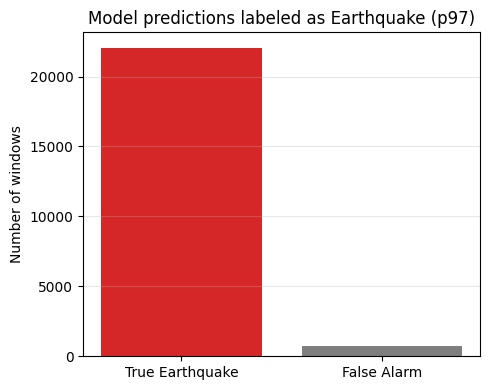

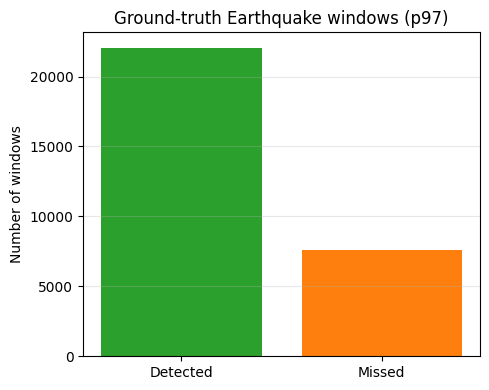


📊 ANALYSIS FOR p99 THRESHOLD
Threshold (p99): 1.43319718e-04
TP: 15981 FP: 247 FN: 13662 TN: 24434
Precision: 0.985
Recall   : 0.539


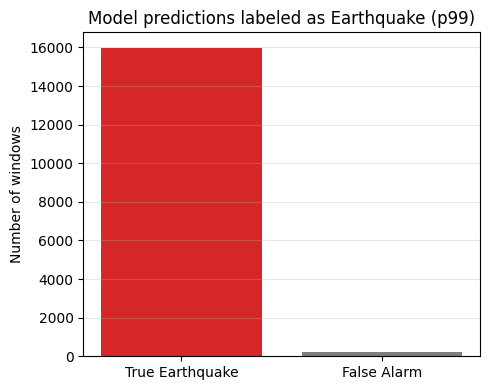

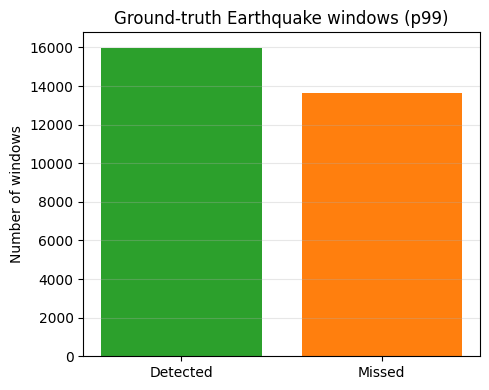

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# sadece noise error'ları
noise_errors = errors[y == 0]

for P in [97, 99]:
    print("\n" + "="*50)
    print(f"📊 ANALYSIS FOR p{P} THRESHOLD")
    print("="*50)

    THRESHOLD = np.percentile(noise_errors, P)
    print(f"Threshold (p{P}): {THRESHOLD:.8e}")

    # -------------------------
    # Model kararları
    # -------------------------
    y_pred = (errors > THRESHOLD).astype(int)

    TP = np.sum((y_pred == 1) & (y == 1))
    FP = np.sum((y_pred == 1) & (y == 0))
    FN = np.sum((y_pred == 0) & (y == 1))
    TN = np.sum((y_pred == 0) & (y == 0))

    precision = TP / (TP + FP + 1e-9)
    recall    = TP / (TP + FN + 1e-9)

    print("TP:", TP, "FP:", FP, "FN:", FN, "TN:", TN)
    print(f"Precision: {precision:.3f}")
    print(f"Recall   : {recall:.3f}")

    # =========================
    # GRAFİK 1
    # Modelin 'deprem' dediklerinin içeriği
    # =========================
    plt.figure(figsize=(5,4))
    plt.bar(
        ["True Earthquake", "False Alarm"],
        [TP, FP],
        color=["tab:red", "tab:gray"]
    )
    plt.title(f"Model predictions labeled as Earthquake (p{P})")
    plt.ylabel("Number of windows")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # =========================
    # GRAFİK 2
    # Gerçek depremlerin ne kadarı yakalanmış?
    # =========================
    plt.figure(figsize=(5,4))
    plt.bar(
        ["Detected", "Missed"],
        [TP, FN],
        color=["tab:green", "tab:orange"]
    )
    plt.title(f"Ground-truth Earthquake windows (p{P})")
    plt.ylabel("Number of windows")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


🔹 Loading trained 1D-CNN Autoencoder...
✅ Model loaded

🔹 Loading test dataset...
✅ Dataset loaded
   Total windows: 54324
   Noise windows: 24681
   EQ windows: 29643

🔹 Computing reconstruction errors...
✅ Reconstruction complete
   Mean error: 0.000433
   Std error: 0.002124

🔹 Computing ROC curve...
✅ ROC AUC: 0.9495

🎯 OPTIMAL THRESHOLD SELECTION

1️⃣  YOUDEN'S J STATISTIC (TPR - FPR)
   Optimal threshold: 0.00003043
   TPR: 0.901
   FPR: 0.100
   J-score: 0.801

2️⃣  CLOSEST TO TOP-LEFT CORNER (0,1)
   Optimal threshold: 0.00003043
   TPR: 0.901
   FPR: 0.100
   Distance: 0.141

3️⃣  F1-SCORE MAXIMIZATION
   Optimal threshold: 0.00003001
   TPR: 0.903
   FPR: 0.102
   F1-Score: 0.901

📊 PERFORMANCE WITH YOUDEN'S OPTIMAL THRESHOLD

   Threshold: 0.00003043

   Confusion Matrix:
   ┌─────────────┬──────────┬──────────┐
   │             │ Pred: 0  │ Pred: 1  │
   ├─────────────┼──────────┼──────────┤
   │ True: 0     │    22221 │     2460 │
   │ True: 1     │     2938 │    26705 │
 

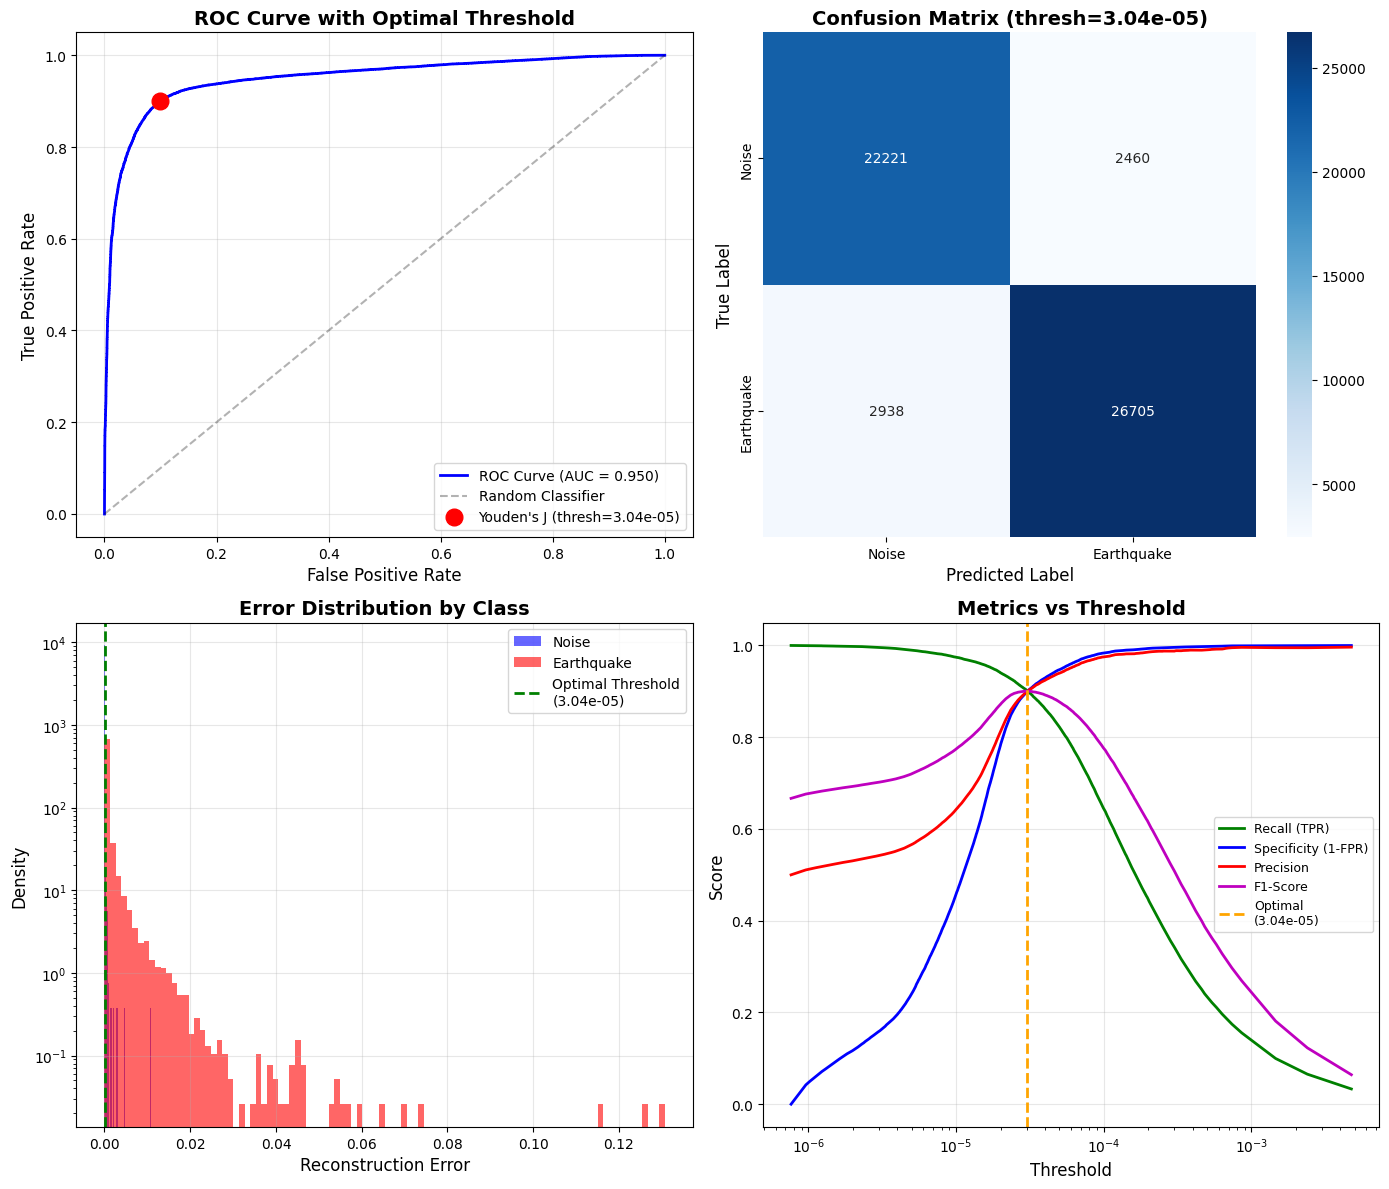


📈 THRESHOLD COMPARISON TABLE

Method          Threshold    Recall   Precision  F1       Accuracy
----------------------------------------------------------------------
p90             0.000030     0.901    0.915      0.908    0.901   
p95             0.000052     0.814    0.951      0.877    0.876   
p97             0.000070     0.744    0.967      0.841    0.847   
p99             0.000143     0.539    0.985      0.697    0.744   
Youden          0.000030     0.901    0.916      0.908    0.901   
Corner          0.000030     0.901    0.916      0.908    0.901   
F1-Max          0.000030     0.903    0.914      0.908    0.901   
✅ ROC-based threshold analysis complete!


In [7]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# =========================
# PATHS
# =========================
MODEL_PATH = "./cnn_ae_best.keras"
TEST_NPZ   = "/Users/selinbardakci/BitirmeProjesi/data/custom_window_test.npz"

# =========================
# LOAD MODEL
# =========================
print("🔹 Loading trained 1D-CNN Autoencoder...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded\n")

# =========================
# LOAD TEST DATA
# =========================
print("🔹 Loading test dataset...")
data = np.load(TEST_NPZ)
X = data["X"]   # (N, 128, 1)
y = data["y"]   # (N,)

print(f"✅ Dataset loaded")
print(f"   Total windows: {len(X)}")
print(f"   Noise windows: {(y==0).sum()}")
print(f"   EQ windows: {(y==1).sum()}\n")

# =========================
# COMPUTE RECONSTRUCTION ERROR
# =========================
print("🔹 Computing reconstruction errors...")
X_hat = model.predict(X, batch_size=256, verbose=0)
errors = np.mean((X - X_hat) ** 2, axis=(1, 2))

print(f"✅ Reconstruction complete")
print(f"   Mean error: {errors.mean():.6f}")
print(f"   Std error: {errors.std():.6f}\n")

# =========================
# ROC CURVE
# =========================
print("🔹 Computing ROC curve...")
fpr, tpr, thresholds = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

print(f"✅ ROC AUC: {roc_auc:.4f}\n")

# =========================
# OPTIMAL THRESHOLD METHODS
# =========================
print("="*70)
print("🎯 OPTIMAL THRESHOLD SELECTION")
print("="*70)

# Method 1: Youden's J statistic (maximize TPR - FPR)
j_scores = tpr - fpr
optimal_idx_youden = np.argmax(j_scores)
optimal_threshold_youden = thresholds[optimal_idx_youden]

print(f"\n1️⃣  YOUDEN'S J STATISTIC (TPR - FPR)")
print(f"   Optimal threshold: {optimal_threshold_youden:.8f}")
print(f"   TPR: {tpr[optimal_idx_youden]:.3f}")
print(f"   FPR: {fpr[optimal_idx_youden]:.3f}")
print(f"   J-score: {j_scores[optimal_idx_youden]:.3f}")

# Method 2: Closest to top-left corner (0,1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
optimal_idx_corner = np.argmin(distances)
optimal_threshold_corner = thresholds[optimal_idx_corner]

print(f"\n2️⃣  CLOSEST TO TOP-LEFT CORNER (0,1)")
print(f"   Optimal threshold: {optimal_threshold_corner:.8f}")
print(f"   TPR: {tpr[optimal_idx_corner]:.3f}")
print(f"   FPR: {fpr[optimal_idx_corner]:.3f}")
print(f"   Distance: {distances[optimal_idx_corner]:.3f}")

# Method 3: F1-Score maximization
precisions = tpr / (tpr + fpr + 1e-10)
f1_scores = 2 * (precisions * tpr) / (precisions + tpr + 1e-10)
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]

print(f"\n3️⃣  F1-SCORE MAXIMIZATION")
print(f"   Optimal threshold: {optimal_threshold_f1:.8f}")
print(f"   TPR: {tpr[optimal_idx_f1]:.3f}")
print(f"   FPR: {fpr[optimal_idx_f1]:.3f}")
print(f"   F1-Score: {f1_scores[optimal_idx_f1]:.3f}")

# =========================
# EVALUATE WITH YOUDEN'S THRESHOLD (RECOMMENDED)
# =========================
OPTIMAL_THRESHOLD = optimal_threshold_youden
y_pred = (errors > OPTIMAL_THRESHOLD).astype(int)

cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
specificity = tn / (tn + fp + 1e-9)

print("\n" + "="*70)
print("📊 PERFORMANCE WITH YOUDEN'S OPTIMAL THRESHOLD")
print("="*70)
print(f"\n   Threshold: {OPTIMAL_THRESHOLD:.8f}")
print(f"\n   Confusion Matrix:")
print(f"   ┌─────────────┬──────────┬──────────┐")
print(f"   │             │ Pred: 0  │ Pred: 1  │")
print(f"   ├─────────────┼──────────┼──────────┤")
print(f"   │ True: 0     │ {tn:8d} │ {fp:8d} │")
print(f"   │ True: 1     │ {fn:8d} │ {tp:8d} │")
print(f"   └─────────────┴──────────┴──────────┘")
print(f"\n   Metrics:")
print(f"   • Accuracy:    {accuracy:.3f}")
print(f"   • Precision:   {precision:.3f}")
print(f"   • Recall:      {recall:.3f}")
print(f"   • F1-Score:    {f1:.3f}")
print(f"   • Specificity: {specificity:.3f}")
print(f"   • ROC AUC:     {roc_auc:.3f}")

# =========================
# VISUALIZATIONS
# =========================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curve with optimal point
ax1 = axes[0, 0]
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
ax1.plot(fpr[optimal_idx_youden], tpr[optimal_idx_youden], 'ro', 
         markersize=12, label=f"Youden's J (thresh={optimal_threshold_youden:.2e})")
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve with Optimal Threshold', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(alpha=0.3)

# 2. Confusion Matrix Heatmap
ax2 = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax2,
            xticklabels=['Noise', 'Earthquake'],
            yticklabels=['Noise', 'Earthquake'])
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title(f'Confusion Matrix (thresh={OPTIMAL_THRESHOLD:.2e})', 
              fontsize=14, fontweight='bold')

# 3. Error Distribution with Threshold
ax3 = axes[1, 0]
noise_errors = errors[y == 0]
eq_errors = errors[y == 1]

ax3.hist(noise_errors, bins=100, alpha=0.6, color='blue', label='Noise', density=True)
ax3.hist(eq_errors, bins=100, alpha=0.6, color='red', label='Earthquake', density=True)
ax3.axvline(OPTIMAL_THRESHOLD, color='green', linestyle='--', linewidth=2, 
            label=f'Optimal Threshold\n({OPTIMAL_THRESHOLD:.2e})')
ax3.set_xlabel('Reconstruction Error', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Error Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_yscale('log')

# 4. Metrics vs Threshold
ax4 = axes[1, 1]
sample_indices = np.linspace(0, len(thresholds)-1, 1000, dtype=int)
ax4.plot(thresholds[sample_indices], tpr[sample_indices], 'g-', label='Recall (TPR)', linewidth=2)
ax4.plot(thresholds[sample_indices], 1-fpr[sample_indices], 'b-', label='Specificity (1-FPR)', linewidth=2)
ax4.plot(thresholds[sample_indices], precisions[sample_indices], 'r-', label='Precision', linewidth=2)
ax4.plot(thresholds[sample_indices], f1_scores[sample_indices], 'm-', label='F1-Score', linewidth=2)
ax4.axvline(OPTIMAL_THRESHOLD, color='orange', linestyle='--', linewidth=2, 
            label=f'Optimal\n({OPTIMAL_THRESHOLD:.2e})')
ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
ax4.set_xscale('log')
ax4.legend(loc='best', fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =========================
# COMPARISON TABLE
# =========================
print("\n" + "="*70)
print("📈 THRESHOLD COMPARISON TABLE")
print("="*70)

comparison_thresholds = {
    "p90": np.percentile(noise_errors, 90),
    "p95": np.percentile(noise_errors, 95),
    "p97": np.percentile(noise_errors, 97),
    "p99": np.percentile(noise_errors, 99),
    "Youden": optimal_threshold_youden,
    "Corner": optimal_threshold_corner,
    "F1-Max": optimal_threshold_f1
}

print(f"\n{'Method':<15} {'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'Accuracy':<8}")
print("-" * 70)

for name, thresh in comparison_thresholds.items():
    y_p = (errors > thresh).astype(int)
    cm_temp = confusion_matrix(y, y_p)
    tn_t, fp_t, fn_t, tp_t = cm_temp.ravel()
    
    acc = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    prec = tp_t / (tp_t + fp_t + 1e-9)
    rec = tp_t / (tp_t + fn_t + 1e-9)
    f1_t = 2 * (prec * rec) / (prec + rec + 1e-9)
    
    print(f"{name:<15} {thresh:<12.6f} {rec:<8.3f} {prec:<10.3f} {f1_t:<8.3f} {acc:<8.3f}")

print("="*70)
print("✅ ROC-based threshold analysis complete!")
print("="*70)

In [15]:
from sklearn.metrics import precision_recall_curve, matthews_corrcoef, confusion_matrix
import numpy as np

print("\n🔧 Adding advanced thresholding methods (NumPy-only)...\n")

advanced_thresholds = {}

# ============================================================
# 0) BASIC NOISE SUBSET
# ============================================================
noise_errors = errors[y == 0]


# ============================================================
# 1) PR-F1 MAX THRESHOLD
# ============================================================
precisions_pr, recalls_pr, th_pr = precision_recall_curve(y, errors)
f1_pr = 2 * (precisions_pr * recalls_pr) / (precisions_pr + recalls_pr + 1e-9)
idx_f1_pr = np.argmax(f1_pr)
th_pr_f1 = th_pr[idx_f1_pr]
advanced_thresholds["PR-F1-Max"] = th_pr_f1


# ============================================================
# 2) MCC-MAX THRESHOLD
# ============================================================
best_mcc = -1
best_th_mcc = None

for th in thresholds:
    y_pred = (errors > th).astype(int)
    mcc = matthews_corrcoef(y, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_th_mcc = th

advanced_thresholds["MCC-Max"] = best_th_mcc


# ============================================================
# 3) G-MEAN MAX THRESHOLD
# ============================================================
gmean = np.sqrt(tpr * (1 - fpr))
idx_gmean = np.argmax(gmean)
th_gmean = thresholds[idx_gmean]
advanced_thresholds["G-Mean-Max"] = th_gmean


# ============================================================
# 4) PRECISION ≥ 0.95 Threshold (maximize recall)
# ============================================================
best_rec = -1
best_th_prec95 = None

for th in thresholds:
    y_pred = (errors > th).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    precision_curr = tp / (tp + fp + 1e-9)
    recall_curr = tp / (tp + fn + 1e-9)

    if precision_curr >= 0.95 and recall_curr > best_rec:
        best_rec = recall_curr
        best_th_prec95 = th

advanced_thresholds["Prec≥0.95"] = best_th_prec95


# ============================================================
# 5) k-SIGMA THRESHOLD (Noise-only)
# ============================================================
mu = noise_errors.mean()
sigma = noise_errors.std()
k = 4.0   # changeable
th_ksigma = mu + k * sigma
advanced_thresholds["kSigma(k=4)"] = th_ksigma


# ============================================================
# 6) MAD THRESHOLD (Noise-only)
# ============================================================
median = np.median(noise_errors)
mad = np.median(np.abs(noise_errors - median))
k_mad = 6.0
th_mad = median + k_mad * mad
advanced_thresholds["MAD(k=6)"] = th_mad


# ============================================================
# 7) NUMPY-ONLY KMEANS (2 clusters)
# ============================================================
def kmeans_1d_threshold(errors, max_iter=100):
    e = errors.reshape(-1, 1).astype(float)

    # initialize cluster centers at min and max
    c1 = np.min(e)
    c2 = np.max(e)

    for _ in range(max_iter):
        # assign clusters
        labels = np.where(np.abs(e - c1) < np.abs(e - c2), 0, 1)

        new_c1 = np.mean(e[labels == 0])
        new_c2 = np.mean(e[labels == 1])

        # break on convergence
        if np.isclose(c1, new_c1) and np.isclose(c2, new_c2):
            break

        c1, c2 = new_c1, new_c2

    centers = np.sort([c1, c2])
    return (centers[0] + centers[1]) / 2.0

th_kmeans = kmeans_1d_threshold(errors)
advanced_thresholds["KMeans"] = th_kmeans


# ============================================================
# 8) NUMPY-ONLY OTSU THRESHOLD
# ============================================================
def otsu_threshold(errs):
    errs = np.sort(errs)
    hist, bin_edges = np.histogram(errs, bins=256)
    hist = hist.astype(float)

    # normalized histogram
    p = hist / np.sum(hist)
    omega = np.cumsum(p)
    mu = np.cumsum(p * np.arange(256))
    mu_t = mu[-1]

    sigma_b = (mu_t * omega - mu)**2 / (omega * (1 - omega) + 1e-9)
    idx = np.argmax(sigma_b)
    return bin_edges[idx]

th_otsu = otsu_threshold(errors)
advanced_thresholds["Otsu"] = th_otsu


# ============================================================
# MERGE WITH ORIGINAL TABLE
# ============================================================
comparison_thresholds.update(advanced_thresholds)


# ============================================================
# PRINT EXTENDED TABLE
# ============================================================
print("\n" + "="*70)
print("📈 EXTENDED THRESHOLD COMPARISON TABLE")
print("="*70)
print(f"\n{'Method':<15} {'Threshold':<12} {'Recall':<8} {'Precision':<10} {'F1':<8} {'Accuracy':<8}")
print("-" * 70)

for name, thresh in comparison_thresholds.items():
    y_p = (errors > thresh).astype(int)
    tn_t, fp_t, fn_t, tp_t = confusion_matrix(y, y_p).ravel()
    
    acc = (tp_t + tn_t) / (tp_t + tn_t + fp_t + fn_t)
    prec = tp_t / (tp_t + fp_t + 1e-9)
    rec = tp_t / (tp_t + fn_t + 1e-9)
    f1_t = 2 * (prec * rec) / (prec + rec + 1e-9)
    
    print(f"{name:<15} {thresh:<12.6f} {rec:<8.3f} {prec:<10.3f} {f1_t:<8.3f} {acc:<8.3f}")

print("="*70)
print("✅ NumPy-only advanced threshold analysis complete!")
print("="*70)



🔧 Adding advanced thresholding methods (NumPy-only)...


📈 EXTENDED THRESHOLD COMPARISON TABLE

Method          Threshold    Recall   Precision  F1       Accuracy
----------------------------------------------------------------------
p90             0.000030     0.901    0.915      0.908    0.901   
p95             0.000052     0.814    0.951      0.877    0.876   
p97             0.000070     0.744    0.967      0.841    0.847   
p99             0.000143     0.539    0.985      0.697    0.744   
Youden          0.000030     0.901    0.916      0.908    0.901   
Corner          0.000030     0.901    0.916      0.908    0.901   
F1-Max          0.000030     0.903    0.914      0.908    0.901   
PR-F1-Max       0.000029     0.905    0.912      0.908    0.900   
MCC-Max         0.000030     0.901    0.916      0.908    0.901   
G-Mean-Max      0.000030     0.901    0.916      0.908    0.901   
Prec≥0.95       0.000051     0.819    0.950      0.880    0.878   
kSigma(k=4)     0.000483    